In [23]:
import numpy as np
import tifffile
from scipy import stats
from scipy import ndimage
from skimage import filters
from skimage import feature
import matplotlib.pyplot as plt
from skimage.util import view_as_windows
import warnings
warnings.filterwarnings('ignore')

class FluorescenceNoiseAnalyzer:
    """
    A class to analyze noise in fluorescence microscopy images.
    Implements multiple noise analysis methods specifically tailored for fluorescence microscopy.
    """

    def __init__(self, image_path):
        """Initialize with an image path and load the image."""
        self.image = tifffile.imread(image_path)
        self.image_float = self.image.astype(float)

    def estimate_background(self, method='adaptive', block_size=51, offset=10):
        """
        Improved background estimation with multiple methods.

        Parameters:
        - method: 'adaptive', 'percentile', or 'rolling_ball'
        - block_size: size of local neighborhood for adaptive method
        - offset: sensitivity adjustment
        """
        if method == 'adaptive':
            # Use adaptive thresholding with larger window
            thresh = filters.threshold_local(self.image, block_size, offset=offset)
            self.background_mask = self.image < thresh

        elif method == 'percentile':
            # Use a percentile-based approach
            thresh = np.percentile(self.image, 10)  # bottom 10% as background
            self.background_mask = self.image < thresh

        elif method == 'rolling_ball':
            # Rolling ball algorithm (common in microscopy)
            from skimage.morphology import rolling_ball
            background = rolling_ball(self.image, radius=50)
            self.background_mask = self.image < (background + offset)

        self.background_pixels = self.image_float[self.background_mask]
        return self.background_mask

    def calculate_basic_statistics(self):
        """
        Calculate basic statistical measures of noise.
        Returns SNR and background statistics.
        """
        # Calculate global statistics
        global_mean = np.mean(self.image_float)
        global_std = np.std(self.image_float)

        # Calculate background statistics
        bg_mean = np.mean(self.background_pixels)
        bg_std = np.std(self.background_pixels)

        # Calculate signal region (non-background) statistics
        signal_mask = ~self.background_mask
        signal_pixels = self.image_float[signal_mask]
        signal_mean = np.mean(signal_pixels)

        # Calculate Signal-to-Noise Ratio
        snr = (signal_mean - bg_mean) / bg_std if bg_std != 0 else float('inf')

        return {
            'global_mean': global_mean,
            'global_std': global_std,
            'background_mean': bg_mean,
            'background_std': bg_std,
            'signal_mean': signal_mean,
            'snr': snr
        }

    def analyze_noise_distribution(self):
        """
        Analyze the statistical distribution of noise in the background.
        For fluorescence microscopy, we expect a mixture of Poisson (from photon detection)
        and Gaussian noise (from detector electronics).
        """
        # For Poisson noise analysis
        # Instead of fitting, we estimate lambda parameter as the mean
        # This works because for Poisson distribution, mean = variance = lambda
        poisson_lambda = np.mean(self.background_pixels)

        # Generate theoretical Poisson distribution with this lambda
        # We need to use integers for Poisson
        background_ints = self.background_pixels.astype(int)
        poisson_ks_stat, poisson_p_value = stats.kstest(
            background_ints,
            lambda x: stats.poisson.cdf(x, poisson_lambda)
        )

        # For Gaussian noise (from detector)
        # We can use fit here because Gaussian is a continuous distribution
        gaussian_params = stats.norm.fit(self.background_pixels)
        gaussian_ks_stat, gaussian_p_value = stats.kstest(
            self.background_pixels,
            'norm',
            gaussian_params
        )

        return {
            'poisson_fit': {
                'lambda': poisson_lambda,
                'ks_statistic': poisson_ks_stat,
                'p_value': poisson_p_value
            },
            'gaussian_fit': {
                'params': gaussian_params,
                'ks_statistic': gaussian_ks_stat,
                'p_value': gaussian_p_value
            }
        }

    def analyze_spatial_noise(self, patch_size=64):
        """
        Analyze how noise varies spatially across the image.
        Uses patch-based analysis.
        """
        # Create patches of the image
        patches = view_as_windows(self.image_float,
                                window_shape=(patch_size, patch_size),
                                step=patch_size)

        # Calculate local statistics for each patch
        local_means = np.mean(patches, axis=(2, 3))
        local_stds = np.std(patches, axis=(2, 3))

        # Calculate coefficient of variation for each patch
        local_cv = local_stds / local_means

        return {
            'local_means': local_means,
            'local_stds': local_stds,
            'local_cv': local_cv
        }

    def analyze_frequency_noise(self):
        """
        Analyze noise in the frequency domain.
        Useful for identifying periodic noise patterns.
        """
        # Compute 2D FFT
        fft = np.fft.fft2(self.image_float)
        fft_shifted = np.fft.fftshift(fft)
        power_spectrum = np.abs(fft_shifted)**2

        # Calculate radial profile of power spectrum
        center = np.array(power_spectrum.shape) // 2
        y, x = np.indices(power_spectrum.shape)
        r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        r = r.astype(int)

        # Calculate the azimuthally averaged radial profile
        radial_prof = np.bincount(r.ravel(), power_spectrum.ravel())
        radial_prof /= np.bincount(r.ravel())

        return {
            'power_spectrum': power_spectrum,
            'radial_profile': radial_prof
        }

    def plot_analysis(self):
        """
        Create comprehensive visualization of noise analysis results.
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Original image
        axes[0, 0].imshow(self.image, cmap='gray')
        axes[0, 0].set_title('Original Image')

        # Background mask
        axes[0, 1].imshow(self.background_mask, cmap='gray')
        axes[0, 1].set_title('Background Mask')

        # Histogram of background pixels
        axes[0, 2].hist(self.background_pixels, bins=50, density=True)
        axes[0, 2].set_title('Background Intensity Distribution')

        # Power spectrum
        freq_results = self.analyze_frequency_noise()
        axes[1, 0].imshow(np.log10(freq_results['power_spectrum']), cmap='viridis')
        axes[1, 0].set_title('Power Spectrum (log scale)')

        # Radial profile of power spectrum
        axes[1, 1].plot(freq_results['radial_profile'])
        axes[1, 1].set_title('Radial Power Spectrum Profile')
        axes[1, 1].set_yscale('log')

        # Spatial noise variation
        spatial_results = self.analyze_spatial_noise()
        im = axes[1, 2].imshow(spatial_results['local_cv'], cmap='viridis')
        axes[1, 2].set_title('Local Coefficient of Variation')
        plt.colorbar(im, ax=axes[1, 2])

        plt.tight_layout()
        return fig

def analyze_fluorescence_image(image_path):
    """
    Perform complete noise analysis on a fluorescence microscopy image.
    """
    analyzer = FluorescenceNoiseAnalyzer(image_path)

    # Perform analysis steps
    analyzer.estimate_background()
    basic_stats = analyzer.calculate_basic_statistics()
    dist_analysis = analyzer.analyze_noise_distribution()
    spatial_analysis = analyzer.analyze_spatial_noise()
    freq_analysis = analyzer.analyze_frequency_noise()

    # Print summary
    print("=== Noise Analysis Summary ===")
    print(f"\nBasic Statistics:")
    print(f"Signal-to-Noise Ratio: {basic_stats['snr']:.2f}")
    print(f"Background Standard Deviation: {basic_stats['background_std']:.2f}")

    print("\nNoise Distribution Analysis:")
    print("Poisson fit p-value:", dist_analysis['poisson_fit']['p_value'])
    print("Gaussian fit p-value:", dist_analysis['gaussian_fit']['p_value'])

    # Create visualization
    fig = analyzer.plot_analysis()

    return {
        'basic_stats': basic_stats,
        'distribution_analysis': dist_analysis,
        'spatial_analysis': spatial_analysis,
        'frequency_analysis': freq_analysis,
        'figure': fig
    }

=== Noise Analysis Summary ===

Basic Statistics:
Signal-to-Noise Ratio: -0.30
Background Standard Deviation: 43.74

Noise Distribution Analysis:
Poisson fit p-value: 0.0
Gaussian fit p-value: 0.0


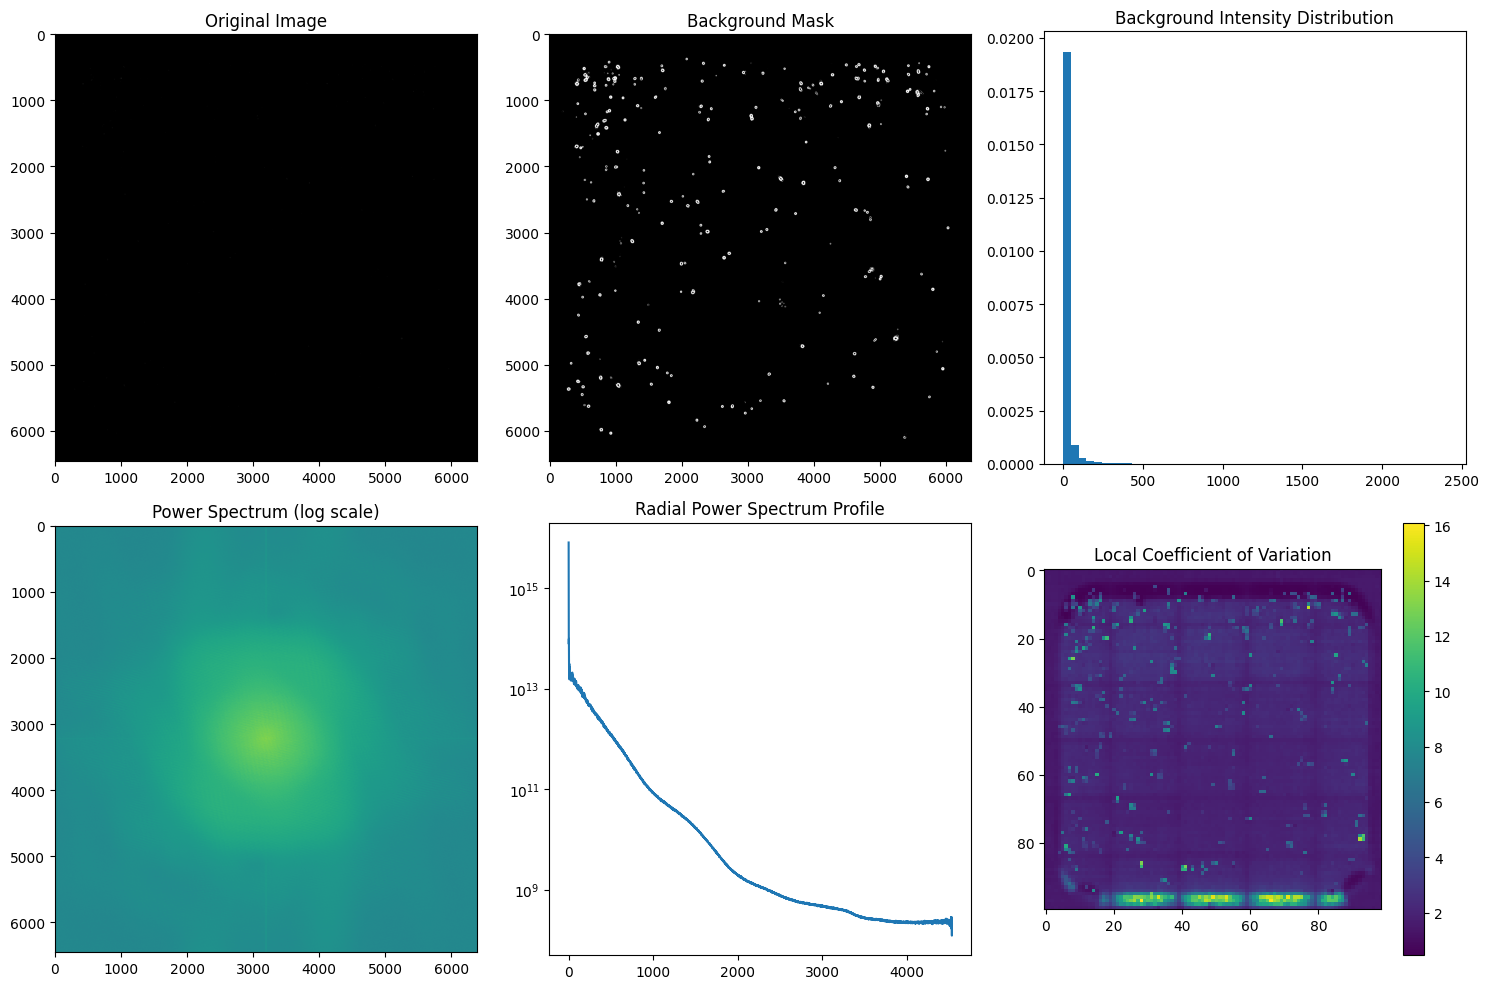

In [24]:
# Analyze a single image
image_path = '../../EXP2111_A06_D#07_T0003_C01.tif'
results = analyze_fluorescence_image(image_path)

# Display the results
plt.show()

In [1]:
import tifffile
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

class MicroscopyNoiseAnalyzer:
    def __init__(self, image_path):
        """
        Initialize with a path to the TIFF file instead of an array.
        This gives us more direct control over image loading.
        """
        # Load and normalize image once to avoid repeated calculations
        self.original_image = tifffile.imread(image_path)
        self.image_float = self.original_image.astype(float)
        self._normalize_image()

    def _normalize_image(self):
        """Normalize image once during initialization"""
        img_min = self.image_float.min()
        img_max = self.image_float.max()
        self.normalized_image = (self.image_float - img_min) / (img_max - img_min)

    def analyze_all_noise(self, row_step=10, col_step=10, patch_size=50):
        """
        Comprehensive but efficient noise analysis.

        Parameters:
        row_step: Step size for sampling rows (higher = faster but less precise)
        col_step: Step size for sampling columns
        patch_size: Size of patches for local noise analysis
        """
        # Analyze grid pattern through sampling
        row_profile = np.mean(self.normalized_image[::row_step], axis=1)
        col_profile = np.mean(self.normalized_image[:,::col_step], axis=0)

        # Sample patches for random noise analysis
        patches = self.normalized_image[::patch_size, ::patch_size]
        noise_level = np.std(patches)

        # Calculate basic statistics efficiently
        signal_regions = self.normalized_image > np.percentile(self.normalized_image, 90)
        background_regions = self.normalized_image < np.percentile(self.normalized_image, 10)

        return {
            'grid_noise': {
                'row_variation': np.std(row_profile),
                'col_variation': np.std(col_profile),
                'profiles': (row_profile, col_profile)
            },
            'random_noise': {
                'level': noise_level,
                'distribution': patches.ravel()
            },
            'signal_stats': {
                'signal_mean': np.mean(self.normalized_image[signal_regions]),
                'background_mean': np.mean(self.normalized_image[background_regions]),
                'snr': (np.mean(self.normalized_image[signal_regions]) -
                       np.mean(self.normalized_image[background_regions])) / noise_level
            }
        }

    def plot_analysis(self):
        """Create visualizations of the noise analysis"""
        # Get all analysis results at once
        results = self.analyze_all_noise()

        fig, axes = plt.subplots(2, 2, figsize=(12, 12))

        # Original image
        axes[0,0].imshow(self.normalized_image, cmap='gray')
        axes[0,0].set_title('Normalized Image')

        # Grid pattern analysis
        axes[0,1].plot(results['grid_noise']['profiles'][0])
        axes[0,1].set_title(f"Row Variation: {results['grid_noise']['row_variation']:.3f}")

        axes[1,0].plot(results['grid_noise']['profiles'][1])
        axes[1,0].set_title(f"Column Variation: {results['grid_noise']['col_variation']:.3f}")

        # Noise distribution
        axes[1,1].hist(results['random_noise']['distribution'], bins=50)
        axes[1,1].set_title(f"Noise Level: {results['random_noise']['level']:.3f}")

        plt.tight_layout()
        return fig, results

# Simple usage example:
def analyze_microscopy_image(image_path):
    """Wrapper function for easy analysis of a single image"""
    analyzer = MicroscopyNoiseAnalyzer(image_path)
    fig, results = analyzer.plot_analysis()

    print("\nNoise Analysis Results:")
    print(f"Signal-to-Noise Ratio: {results['signal_stats']['snr']:.2f}")
    print(f"Grid Pattern Strength (Row): {results['grid_noise']['row_variation']:.3f}")
    print(f"Grid Pattern Strength (Col): {results['grid_noise']['col_variation']:.3f}")
    print(f"Random Noise Level: {results['random_noise']['level']:.3f}")

    return analyzer, fig, results

/Users/guidoputignano/python/Cellgroup_up/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/guidoputignano/python/Cellgroup_up/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Noise Analysis Results:
Signal-to-Noise Ratio: nan
Grid Pattern Strength (Row): 0.005
Grid Pattern Strength (Col): 0.004
Random Noise Level: 0.018


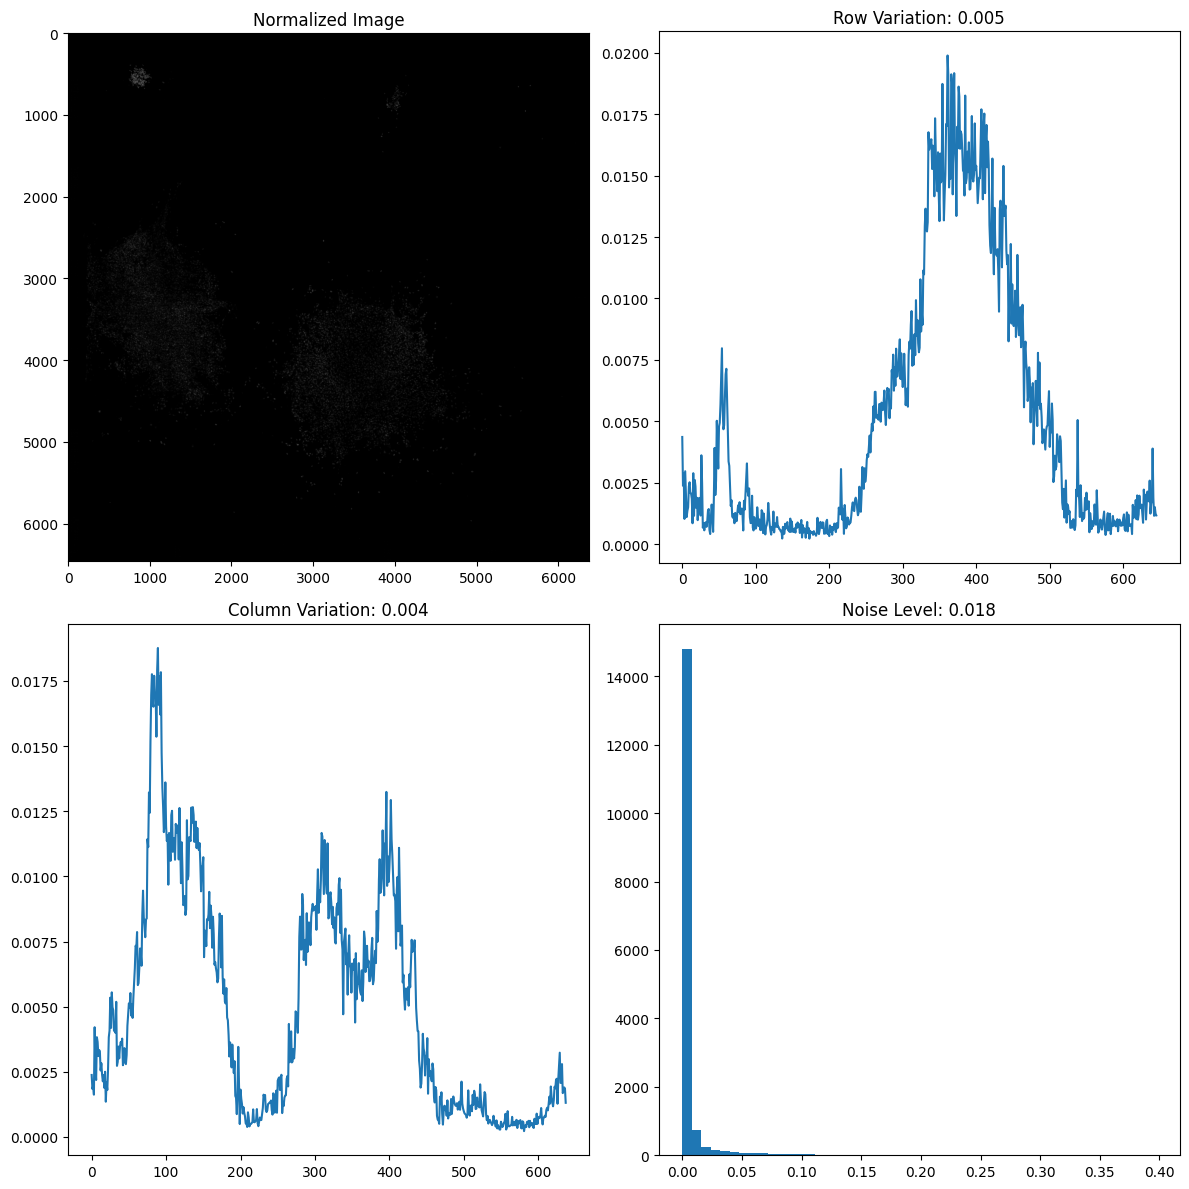

In [4]:
image_path = 'y/Users/guidoputignano/PycharmProjects/Cellgroup_new/Cellgroup_up/EXP2111_A06_D#07_T0003_C01.tif'
analyzer, fig, results = analyze_microscopy_image(image_path)
plt.show()